<a href="https://www.kaggle.com/code/uvinir/imdb-dataset-text-classification?scriptVersionId=113609706" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Text Classification Using Supervised Learning Algorithms**

This notebook will give you a breif idea on **Natural Language Processing** **using** **python** libraries.

The famous **imdb-datset** has been used here, which includes 50000 movie reviews classified as positive and negative.The aim of this study is to classify a new entry as either a positive review or a negative review.

### Install packages

In [1]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s s eta 0:00:01
     |████████████████████████████████| 199 kB 65.5 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=046963f708df83ddd279e10fa3c0b8a9733466463a1dbe0eaf1e1bd175d47fbc
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [2]:
# pnadas to read data frames
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# for sql queries
from pyspark.sql import SparkSession
from pyspark.sql import Row
import types
from pyspark.sql.types import *
from pyspark import SparkContext 
sc = SparkContext.getOrCreate() 
spark = SparkSession.builder.getOrCreate()

# for NLP
import re #regular expressions
import nltk 
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
import string

# for train test split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Supervised learning algorithms  
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# For algorithm evalution
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/12 11:21:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
# read data file
movie_df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
movie_df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
# remove duplicates
movie_df['dup'] = movie_df.duplicated(subset=None, keep='first')
del movie_df['dup']

### Class Balanced Data

In [6]:
# Applying SQL operations to create data frame
classNameContent = StructType([StructField("review", StringType(), True),
                               StructField("sentiment",  StringType(), True)])
FinalDataSet = spark.createDataFrame(movie_df, classNameContent)
FinalDataSet.createTempView("MovieReviews")

# Check for class balanced nature
print("Total number of Reviews: " + str(FinalDataSet.count()) )
spark.sql(
    "select sentiment, count(sentiment) as count " +
    "from MovieReviews " +
    "group by sentiment "
    "order by sentiment limit 20" ).show()

22/12/12 11:21:59 WARN TaskSetManager: Stage 0 contains a task of very large size (15881 KiB). The maximum recommended task size is 1000 KiB.


Total number of Reviews: 50000
22/12/12 11:22:02 WARN TaskSetManager: Stage 3 contains a task of very large size (15881 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----+
|sentiment|count|
+---------+-----+
| negative|25000|
| positive|25000|
+---------+-----+



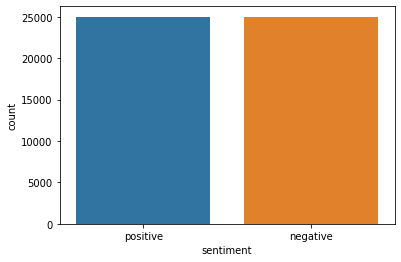

In [7]:
# Visualise class blanace nature
ax = sns.countplot(x="sentiment", data=movie_df)

### Pre Processing

In [8]:
# apply pre processing 

sw = stopwords.words('english') # call stopwords from nltk
lemmatizer = WordNetLemmatizer() # call Lemmatisation from nltk

# get a customised stopwords list
stop_words_file = '/kaggle/input/smart-stop-list/SmartStoplist.txt' 
stop_words = []
with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split())      
stop_words = stop_words  

# defining the preprocessing function
def preprocess(text):
    
    text = text.lower() #to convert into lowercase
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw] #removing stopwords
    
    
    text = [lemmatizer.lemmatize(word) for word in text if lemmatizer.lemmatize(word) not in stop_words]
    text = " ".join(text) #Lemmatisation 
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [9]:
# Apply preprocessing to review column
movie_df['prep'] = movie_df['review'].apply(lambda x: preprocess(x)) 
del movie_df['review'] # remove review column
movie_df.head(5)

,sentiment,prep
0,positive,reviewer mentioned watching oz episode hooked ...
1,positive,wonderful production filming technique unassum...
2,positive,thought wonderful spend time hot summer weeken...
3,negative,basically family boy jake zombie closet parent...
4,positive,petter mattei love time money visually stunnin...


In [10]:
# observe a sample Review 
sample_corpora = movie_df['prep'].iloc[:1].values
sample_corpora 

array(['reviewer mentioned watching oz episode hooked happened thing struck oz brutality unflinching scene violence set trust show faint hearted timid show pull punch regard drug sex violence hardcore classic called oz nickname oswald maximum security state penitentary focus emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement main appeal show due fact show dare forget pretty picture painted mainstream audience forget charm forget romanceoz mess episode struck nasty surreal ready watched developed taste oz accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz comfortable uncomfortable viewingthats touch darker side'],
      dtype=object)

### Tokenisation

In [11]:
# sql query to store the pre preprosessed data 
FinalDataSet=spark.createDataFrame(movie_df) 
FinalDataSet.printSchema()
FinalDataSet.show(2)

root
 |-- sentiment: string (nullable = true)
 |-- prep: string (nullable = true)

22/12/12 11:25:15 WARN TaskSetManager: Stage 6 contains a task of very large size (8051 KiB). The maximum recommended task size is 1000 KiB.
+---------+--------------------+
|sentiment|                prep|
+---------+--------------------+
| positive|reviewer mentione...|
| positive|wonderful product...|
+---------+--------------------+
only showing top 2 rows



In [12]:
# Convert sentiment into binary values
classes=["negative", "positive"]
classIx=[0,1]
classLookupMap=dict(zip(classes,classIx))

In [13]:
# Tokenize the content and convert the sentiment to a number
# Convert content to array of words
AllTokens_df = FinalDataSet.rdd.map(lambda text: Row(sentiment=classLookupMap[text[0]],prep=re.findall(r"[\w']+" ,text[1].lower())) ).toDF()

AllTokens_df.registerTempTable("allTokens")
AllTokens_df.printSchema()
AllTokens_df.show(2)

22/12/12 11:25:23 WARN TaskSetManager: Stage 7 contains a task of very large size (8051 KiB). The maximum recommended task size is 1000 KiB.
root
 |-- sentiment: long (nullable = true)
 |-- prep: array (nullable = true)
 |    |-- element: string (containsNull = true)

22/12/12 11:25:23 WARN TaskSetManager: Stage 8 contains a task of very large size (8051 KiB). The maximum recommended task size is 1000 KiB.
+---------+--------------------+
|sentiment|                prep|
+---------+--------------------+
|        1|[reviewer, mentio...|
|        1|[wonderful, produ...|
+---------+--------------------+
only showing top 2 rows



In [14]:
# Split all the text files using non-Word characters 
AllTokensNonWordSplit = FinalDataSet.select('prep').rdd.flatMap(
                        lambda text: re.findall(r"[\w']+", text.prep.lower()) )

print("Number of tokens: " + str(AllTokensNonWordSplit.count()) ) # all tokens
print("Number of distinct tokens: " + str(AllTokensNonWordSplit.distinct().count()) ) # distinct tokens

22/12/12 11:25:26 WARN TaskSetManager: Stage 9 contains a task of very large size (8051 KiB). The maximum recommended task size is 1000 KiB.


Number of tokens: 4687353
22/12/12 11:25:28 WARN TaskSetManager: Stage 10 contains a task of very large size (8051 KiB). The maximum recommended task size is 1000 KiB.


Number of distinct tokens: 107737


In [15]:
# spread of tokens per review
spark.sql("""
  select min(sz) minimum, avg(sz) average, max(sz) maximum
  from (
    select size(prep) sz
    from allTokens
  )
""").show()

22/12/12 11:25:35 WARN TaskSetManager: Stage 12 contains a task of very large size (8051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------+-------+
|minimum| average|maximum|
+-------+--------+-------+
|      3|93.74706|   1191|
+-------+--------+-------+



### Word Cloud

In [16]:
# Most common token
tokens = StructType([StructField("token",  StringType(), True)])

# Create a dataframe
AllTokens = spark.createDataFrame(
                   AllTokensNonWordSplit.map(lambda x:[x]), tokens )

AllTokens.registerTempTable("Tokens")

spark.sql("""
    select token, count(token) tokencount 
    from Tokens 
    group by token 
    order by tokencount desc 
    """).toPandas()

22/12/12 11:25:41 WARN TaskSetManager: Stage 15 contains a task of very large size (8051 KiB). The maximum recommended task size is 1000 KiB.


,token,tokencount
0,movie,102518
1,film,93033
2,time,31250
3,good,29677
4,character,28242
...,...,...
107732,butyears,1
107733,disturbingwithout,1
107734,criccets,1
107735,quells,1


In [17]:
# In case if you need to save all the tokens use the below
# I recommend you to have a look on individual tokens, update your stopword list and redo the above steps

# AllTokensdf = AllTokens.toPandas()
# AllTokensdf = AllTokensdf.groupby("token")["token"].count()
# AllTokensdf.to_csv('/Users/uvini/Downloads/movietokens.csv')

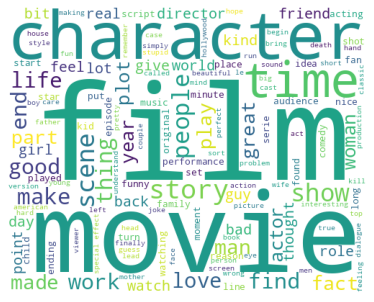

In [18]:
# produce wordclouds
# Suggestion: we can genrate seperate word clouds for each category 

all_words = '' 

# to extract most common words
for arg in movie_df["prep"]: 

    tokens = arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 500, height = 400, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Train-Test Split

In [19]:
X_train, X_test , y_train, y_test = train_test_split(movie_df['prep'].values,
                                                     movie_df['sentiment'].values,test_size=0.2,
                                                     random_state=42,stratify=movie_df['sentiment'].values)

### TF-IDF Vectorisation

In [20]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

## **Supervised Learning Algorithms** 

### Random Forest Classifier

In [21]:
classifier1 = RandomForestClassifier()
classifier1.fit(tfidf_train_vectors,y_train)

y_pred1 = classifier1.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred1))
print("Accuracy score:", accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      5000
    positive       0.85      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy score: 0.8537


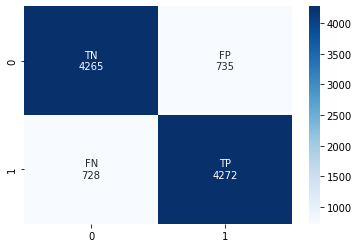

In [22]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred1)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Decision Tree Classifier

In [25]:
classifier2 = DecisionTreeClassifier()
classifier2.fit(tfidf_train_vectors,y_train)

y_pred2 = classifier2.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred2))
print("Accuracy score:", accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

    negative       0.73      0.72      0.73      5000
    positive       0.72      0.74      0.73      5000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

Accuracy score: 0.7276


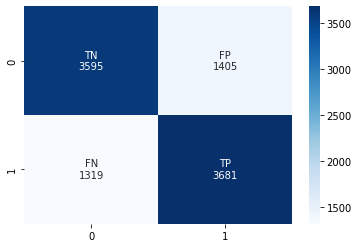

In [26]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred2)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Multinomial Naive Bayes

In [23]:
classifier3 = MultinomialNB()
classifier3.fit(tfidf_train_vectors,y_train)

y_pred3 = classifier3.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred3))
print("Accuracy score:", accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      5000
    positive       0.87      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy score: 0.8639


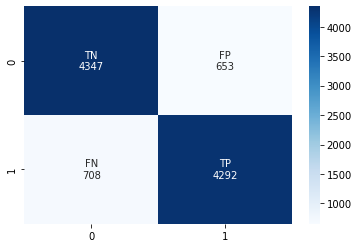

In [24]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred3)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### K Neighbors Classifier

In [27]:
classifier4 = KNeighborsClassifier()
classifier4.fit(tfidf_train_vectors,y_train)

y_pred4 = classifier4.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred4))
print("Accuracy score:", accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

    negative       0.82      0.69      0.75      5000
    positive       0.73      0.85      0.78      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000

Accuracy score: 0.7663


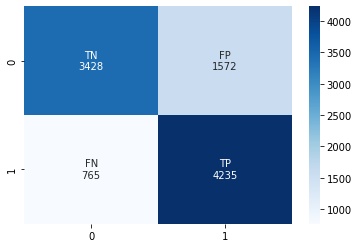

In [28]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred4)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Logistic Regression

In [29]:
classifier5 = LogisticRegression()
classifier5.fit(tfidf_train_vectors,y_train)
y_pred5 = classifier5.predict(tfidf_test_vectors)
print(classification_report(y_test,y_pred5))
print("Accuracy score:", accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

    negative       0.90      0.87      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy score: 0.8867


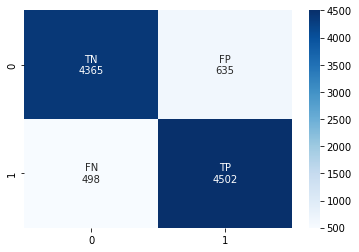

In [30]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred5)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Ada Boost Classifier

In [31]:
classifier6 = AdaBoostClassifier()
classifier6.fit(tfidf_train_vectors,y_train)

y_pred6 = classifier6.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred6))
print("Accuracy score:", accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

    negative       0.83      0.76      0.79      5000
    positive       0.78      0.84      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Accuracy score: 0.8005


> **Additional Models to check out!!!**

### Support Vector Machine Classifier

In [ ]:
classifier7 = SVC()
classifier7.fit(tfidf_train_vectors,y_train)

y_pred7 = classifier7.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred7))
print("Accuracy score:", accuracy_score(y_test,y_pred7))

#### References

[https://github.com/jacquesroy/byte-size-data-science](http://)

[https://github.com/dakshtrehan/Movie-Review-Classifier](http://)

[https://github.com/NajiAboo/TextClassification](http://)